In [1]:
import torch
import numpy as np
import pandas as pd
import pdb
import re
from time import time
import json
import random
import os
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.stats import multivariate_normal, invgamma, mode
from scipy.special import gamma
from functools import partial
from math import ceil

from sklearn.metrics.pairwise import rbf_kernel
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import argparse
import os

from typing import Sequence

from statsmodels.graphics.tsaplots import plot_acf

import statsmodels.api as sm

from torch.utils.data import TensorDataset
from torch.utils.data import Dataset
import torch
from tqdm import tqdm
from torch.autograd import Variable
from torch.autograd import grad as torch_grad
import matplotlib.pyplot as plt
from torch.utils.tensorboard import writer, SummaryWriter
from torch.utils.data import DataLoader
from math import pi


In [2]:
print(torch.cuda.is_available())

True


In [3]:
import statsmodels.tsa.arima_process as smt
class ARMA(Dataset):

    def __init__(self, p: Sequence[float], q: Sequence[float], seed: int = None,
                 n_series: int = 200, datapoints: int = 100):
        """
        Pytorch Dataset to sample a given ARMA process.
        
        y = ARMA(p,q)
        :param p: AR parameters
        :param q: MA parameters
        :param seed: random seed
        :param n_series: number of ARMA samples in your dataset
        :param datapoints: length of each sample
        """
        self.p = p
        self.q = q
        self.n_series = n_series
        self.datapoints = datapoints
        self.seed = seed
        self.scaler = MinMaxScaler((-1,1))

        self.dataset = torch.tensor(self.scaler.fit_transform(self._generate_ARMA())).unsqueeze(2)

    def __len__(self):
        return self.n_series

    def __getitem__(self, idx):
        return self.dataset[idx]


    def _generate_ARMA(self):

        if self.seed is not None:
            np.random.seed(self.seed)

        ar = np.array(self.p)
        ma = np.array(self.q)
        ar = np.r_[1, -ar]
        ma = np.r_[1, ma]
        burn = int(self.datapoints / 10)

        dataset = []

        for i in range(self.n_series):
            arma = smt.arma_generate_sample(ar=ar, ma=ma, nsample=self.datapoints, burnin=burn)
            dataset.append(arma)

        return np.array(dataset)
def get_data(data_type, data_options=None):
    """
    Helper/wrapper function to get the requested data.
    """
    labels = None
    pdf = None
    if data_type == 'load':
        data_dict = np.load(data_options).item()
        samples = data_dict['samples']
        pdf = data_dict['pdf']
        labels = data_dict['labels']
    elif data_type == 'sine':
        samples = sine_wave()
    elif data_type == 'mnist':
        if data_options['full_mnist']:
            samples, labels = mnist()
        else:
            #samples, labels = load_resized_mnist_0_5(14)
            samples, labels = load_resized_mnist(14)       # this is the 0-2 setting
    elif data_type == 'gp_rbf':
        print(data_options)
        samples, pdf = GP(**data_options, kernel='rbf')
    elif data_type == 'linear':
        samples, pdf = linear(**data_options)
    elif data_type == 'eICU_task':
        samples, labels = eICU_task()
    elif data_type == 'resampled_eICU':
        samples, labels = resampled_eICU(**data_options)
    else:
        raise ValueError(data_type)
    print('Generated/loaded', len(samples), 'samples from data-type', data_type)
    return samples, pdf, labels

def sine_wave(seq_length=30, num_samples=28*5*100, num_signals=1, 
        freq_low=1, freq_high=5, amplitude_low = 0.1, amplitude_high=0.9, 
        random_seed=None, **kwargs):

    
    ix = np.arange(seq_length) + 1
    samples = []
    for i in range(num_samples):
        signals = []
        for i in range(num_signals):
            f = np.random.uniform(low=freq_high, high=freq_low)     # frequency
            A = np.random.uniform(low=amplitude_high, high=amplitude_low)        # amplitude
            # offset
            offset = np.random.uniform(low=-np.pi, high=np.pi)
            signals.append(A*np.sin(2*np.pi*f*ix/float(seq_length) + offset))
        samples.append(np.array(signals).T)
    # the shape of the samples is num_samples x seq_length x num_signals
    samples = np.array(samples)
    return samples

def split(samples, proportions, normalise=False, scale=False, labels=None, random_seed=None):
    """
    Return train/validation/test split.
    """
    if random_seed != None:
        random.seed(random_seed)
        np.random.seed(random_seed)
    assert np.sum(proportions) == 1
    n_total = samples.shape[0]
    n_train = ceil(n_total*proportions[0])
    n_test = ceil(n_total*proportions[2])
    n_vali = n_total - (n_train + n_test)
    # permutation to shuffle the samples
    shuff = np.random.permutation(n_total)
    train_indices = shuff[:n_train]
    vali_indices = shuff[n_train:(n_train + n_vali)]
    test_indices = shuff[(n_train + n_vali):]
    # TODO when we want to scale we can just return the indices
    assert len(set(train_indices).intersection(vali_indices)) == 0
    assert len(set(train_indices).intersection(test_indices)) == 0
    assert len(set(vali_indices).intersection(test_indices)) == 0
    # split up the samples
    train = samples[train_indices]
    vali = samples[vali_indices]
    test = samples[test_indices]
    # apply the same normalisation scheme to all parts of the split
    if normalise:
        if scale: raise ValueError(normalise, scale)        # mutually exclusive
        train, vali, test = normalise_data(train, vali, test)
    elif scale:
        train, vali, test = scale_data(train, vali, test)
    if labels is None:
        return train, vali, test
    else:
        print('Splitting labels...')
        if type(labels) == np.ndarray:
            train_labels = labels[train_indices]
            vali_labels = labels[vali_indices]
            test_labels = labels[test_indices]
            labels_split = [train_labels, vali_labels, test_labels]
        elif type(labels) == dict:
            # more than one set of labels!  (weird case)
            labels_split = dict()
            for (label_name, label_set) in labels.items():
                train_labels = label_set[train_indices]
                vali_labels = label_set[vali_indices]
                test_labels = label_set[test_indices]
                labels_split[label_name] = [train_labels, vali_labels, test_labels]
        else:
            raise ValueError(type(labels))
        return train, vali, test, labels_split
    

class SinesDataset(Dataset):

    def __init__(self, sines):

        self.n_series = sines.shape[0]
        self.sines = sines
    def __len__(self):
        return self.n_series

    def __getitem__(self, idx):
        return self.sines[idx]



In [4]:
class Generator(torch.nn.Module):
    """The generator network (encoder) for TimeGAN
    """
    def __init__(self, Z_dim, hidden_dim, num_layers):
        super(Generator, self).__init__()
        self.Z_dim = Z_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Generator Architecture
        self.gen_rnn = torch.nn.GRU(
            input_size=self.Z_dim, 
            hidden_size=self.hidden_dim, 
            num_layers=self.num_layers, 
            batch_first=True
        )
        self.gen_linear = torch.nn.Linear(self.hidden_dim, 1)
        self.gen_tanh = torch.nn.Tanh()

        # Init weights
        # Default weights of TensorFlow is Xavier Uniform for W and 1 or 0 for b
        # Reference: 
        # - https://www.tensorflow.org/api_docs/python/tf/compat/v1/get_variable
        # - https://github.com/tensorflow/tensorflow/blob/v2.3.1/tensorflow/python/keras/layers/legacy_rnn/rnn_cell_impl.py#L484-L614
        with torch.no_grad():
            for name, param in self.gen_rnn.named_parameters():
                if 'weight_ih' in name:
                    torch.nn.init.xavier_uniform_(param.data)
                elif 'weight_hh' in name:
                    torch.nn.init.xavier_uniform_(param.data)
                elif 'bias_ih' in name:
                    param.data.fill_(1)
                elif 'bias_hh' in name:
                    param.data.fill_(0)
            for name, param in self.gen_linear.named_parameters():
                if 'weight' in name:
                    torch.nn.init.xavier_uniform_(param)
                elif 'bias' in name:
                    param.data.fill_(0)

    def forward(self, Z):
        """Takes in random noise (features) and generates synthetic features within the latent space
        Args:
            - Z: input random noise (B x S x Z)
            - T: input temporal information
        Returns:
            - H: embeddings (B x S x E)
        """
        # Dynamic RNN input for ignoring paddings
        # 128 x 100 x 71
        H_o, H_t = self.gen_rnn(Z)
        
        # Pad RNN output back to sequence length
        
        # 128 x 100 x 10
        logits = self.gen_linear(H_o)
        # B x S
        H = self.gen_tanh(logits)
        return H
    
    
    
class Discriminator(torch.nn.Module):
    """The Discriminator network (decoder) for TimeGAN
    """
    def __init__(self, hidden_dim, num_layers):
        super(Discriminator, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        # Discriminator Architecture
        self.dis_rnn = torch.nn.GRU(
            input_size= 1,
            hidden_size=self.hidden_dim, 
            num_layers=self.num_layers, 
            batch_first=True
        )
        self.dis_linear = torch.nn.Linear(self.hidden_dim, 1)
        self.sigmoid = torch.nn.Sigmoid()

        # Init weights
        # Default weights of TensorFlow is Xavier Uniform for W and 1 or 0 for b
        # Reference: 
        # - https://www.tensorflow.org/api_docs/python/tf/compat/v1/get_variable
        # - https://github.com/tensorflow/tensorflow/blob/v2.3.1/tensorflow/python/keras/layers/legacy_rnn/rnn_cell_impl.py#L484-L614
        with torch.no_grad():
            for name, param in self.dis_rnn.named_parameters():
                if 'weight_ih' in name:
                    torch.nn.init.xavier_uniform_(param.data)
                elif 'weight_hh' in name:
                    torch.nn.init.xavier_uniform_(param.data)
                elif 'bias_ih' in name:
                    param.data.fill_(1)
                elif 'bias_hh' in name:
                    param.data.fill_(0)
            for name, param in self.dis_linear.named_parameters():
                if 'weight' in name:
                    torch.nn.init.xavier_uniform_(param)
                elif 'bias' in name:
                    param.data.fill_(0)

    def forward(self, H):
        """Forward pass for predicting if the data is real or synthetic
        Args:
            - H: latent representation (B x S x E)
            - T: input temporal information
        Returns:
            - logits: predicted logits (B x S x 1)
        """
        # Dynamic RNN input for ignoring paddings
        
        # 128 x 100 x 10
        H_o, H_t = self.dis_rnn(H)
        
        # Pad RNN output back to sequence length
        logits = self.dis_linear(H_o)
        return self.sigmoid(logits)

    

In [5]:
def sample_Z(batch_size, seq_length, latent_dim, use_time=False, use_noisy_time=False):
    sample = np.float32(np.random.normal(size=[batch_size, seq_length, latent_dim]))
    if use_time:
        print('WARNING: use_time has different semantics')
        sample[:, :, 0] = np.linspace(0, 1.0/seq_length, num=seq_length)
    #if use_noisy_time or use_time:
    #    # time grid is time_grid_mult times larger than seq_length
    #    time_grid_mult = 5
    #    time_grid = (np.arange(seq_length*time_grid_mult)/((seq_length*time_grid_mult)/2)) - 1
    #    time_axes = []
    #    for i in range(batch_size):
    #        # randomly chose a starting point in the time grid
    #        starting_point = np.random.choice(np.arange(len(time_grid))[:-seq_length])
    #        time_axis = time_grid[starting_point:starting_point+seq_length]
    #        if use_noisy_time:
    #            time_axis += np.random.normal(scale=2.0/len(time_axis), size=len(time_axis))
    #        time_axes.append(time_axis)
    #    sample[:,:,0] = time_axes
    return torch.tensor(sample)


In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 5e-5
epochs = 500
batch_size = 16
samples= ARMA([0.9],[0.9], n_series = 1000)
train_dataloader = DataLoader(samples, batch_size = batch_size, shuffle = True)
gen = Generator(5,100,1).to(device)
dis = Discriminator(100,1).to(device)
g_opt = torch.optim.Adam(gen.parameters(), lr = lr)
dis_opt = torch.optim.Adam(dis.parameters(), lr = lr)
criterion = torch.nn.BCELoss().to(device)
fixed_noise = torch.randn((6,100,5)).to(device)

In [7]:
fake_imgs = []
for epoch in range(epochs):

    for batch_idx, real in enumerate(train_dataloader):
        # train discriminator
        gen.train()
        real = real.float().to(device)
        noise = torch.randn(real.shape[0],100,5).to(device)

        fake = gen(noise)

        dis_real = dis(real).view(-1)
        lossD_real = criterion(dis_real, torch.ones_like(dis_real))

        dis_fake = dis(fake).view(-1)
        lossD_fake = criterion(dis_fake, torch.zeros_like(dis_fake))

        loss_D = (lossD_fake+lossD_real)/2

        dis_opt.zero_grad()
        loss_D.backward()
        torch.nn.utils.clip_grad_norm_(dis.parameters(), 0.5)
        dis_opt.step()
            
            

        if batch_idx % 5 == 0:
            noise = torch.randn(real.shape[0],100,5).to(device)

            fake = gen(noise)

            gen_fake = dis(fake).view(-1)

            lossG = criterion(gen_fake, torch.ones_like(gen_fake))

            g_opt.zero_grad()
            lossG.backward()
            torch.nn.utils.clip_grad_norm_(gen.parameters(),0.5)
            g_opt.step()

    print(f'The current epoch is {epoch} and the current gen loss is {lossG}')
    print(f'The current epoch is {epoch} and the current dist loss is {loss_D}')

    
    with torch.no_grad():
        fake_img = gen(fixed_noise).detach().cpu().numpy()
        fake_imgs.append(fake_img)

The current epoch is 0 and the current gen loss is 0.6852014064788818
The current epoch is 0 and the current dist loss is 0.6999209523200989
The current epoch is 1 and the current gen loss is 0.6993991136550903
The current epoch is 1 and the current dist loss is 0.6925867795944214
The current epoch is 2 and the current gen loss is 0.7177718281745911
The current epoch is 2 and the current dist loss is 0.6738049387931824
The current epoch is 3 and the current gen loss is 0.7276992797851562
The current epoch is 3 and the current dist loss is 0.6570992469787598
The current epoch is 4 and the current gen loss is 0.7127721309661865
The current epoch is 4 and the current dist loss is 0.6848576664924622
The current epoch is 5 and the current gen loss is 0.6716518402099609
The current epoch is 5 and the current dist loss is 0.7209964990615845
The current epoch is 6 and the current gen loss is 0.6706388592720032
The current epoch is 6 and the current dist loss is 0.7194781303405762
The current e

The current epoch is 58 and the current gen loss is 1.4651610851287842
The current epoch is 58 and the current dist loss is 0.9854552149772644
The current epoch is 59 and the current gen loss is 0.8764024376869202
The current epoch is 59 and the current dist loss is 0.8080025911331177
The current epoch is 60 and the current gen loss is 0.6895111203193665
The current epoch is 60 and the current dist loss is 0.7313359975814819
The current epoch is 61 and the current gen loss is 0.6920446753501892
The current epoch is 61 and the current dist loss is 0.6898728013038635
The current epoch is 62 and the current gen loss is 0.6549132466316223
The current epoch is 62 and the current dist loss is 0.5370213985443115
The current epoch is 63 and the current gen loss is 1.1059685945510864
The current epoch is 63 and the current dist loss is 0.2649373412132263
The current epoch is 64 and the current gen loss is 1.8140860795974731
The current epoch is 64 and the current dist loss is 0.1565260887145996

The current epoch is 116 and the current gen loss is 0.6894711256027222
The current epoch is 116 and the current dist loss is 0.6995986104011536
The current epoch is 117 and the current gen loss is 0.7020546793937683
The current epoch is 117 and the current dist loss is 0.677527904510498
The current epoch is 118 and the current gen loss is 0.7162179350852966
The current epoch is 118 and the current dist loss is 0.6390751004219055
The current epoch is 119 and the current gen loss is 0.7253111004829407
The current epoch is 119 and the current dist loss is 0.4138082265853882
The current epoch is 120 and the current gen loss is 1.4189363718032837
The current epoch is 120 and the current dist loss is 0.19307510554790497
The current epoch is 121 and the current gen loss is 1.8895028829574585
The current epoch is 121 and the current dist loss is 0.18005257844924927
The current epoch is 122 and the current gen loss is 1.9933173656463623
The current epoch is 122 and the current dist loss is 0.4

The current epoch is 173 and the current gen loss is 0.8718745112419128
The current epoch is 173 and the current dist loss is 0.7458338737487793
The current epoch is 174 and the current gen loss is 0.7033709287643433
The current epoch is 174 and the current dist loss is 0.6722127199172974
The current epoch is 175 and the current gen loss is 0.689175546169281
The current epoch is 175 and the current dist loss is 0.6015757322311401
The current epoch is 176 and the current gen loss is 0.9472904801368713
The current epoch is 176 and the current dist loss is 0.3122069835662842
The current epoch is 177 and the current gen loss is 1.1103768348693848
The current epoch is 177 and the current dist loss is 0.3408603370189667
The current epoch is 178 and the current gen loss is 1.0655437707901
The current epoch is 178 and the current dist loss is 0.5677706599235535
The current epoch is 179 and the current gen loss is 1.0419102907180786
The current epoch is 179 and the current dist loss is 0.744511

The current epoch is 230 and the current gen loss is 0.6942223906517029
The current epoch is 230 and the current dist loss is 0.6827695965766907
The current epoch is 231 and the current gen loss is 0.6845036745071411
The current epoch is 231 and the current dist loss is 0.6227034330368042
The current epoch is 232 and the current gen loss is 0.9054079055786133
The current epoch is 232 and the current dist loss is 0.3458543121814728
The current epoch is 233 and the current gen loss is 1.1077215671539307
The current epoch is 233 and the current dist loss is 0.5113832950592041
The current epoch is 234 and the current gen loss is 1.0435776710510254
The current epoch is 234 and the current dist loss is 0.45460182428359985
The current epoch is 235 and the current gen loss is 0.9519703388214111
The current epoch is 235 and the current dist loss is 0.832075297832489
The current epoch is 236 and the current gen loss is 0.799650251865387
The current epoch is 236 and the current dist loss is 0.745

The current epoch is 287 and the current gen loss is 0.6758785843849182
The current epoch is 287 and the current dist loss is 0.7072787880897522
The current epoch is 288 and the current gen loss is 0.7031845450401306
The current epoch is 288 and the current dist loss is 0.6834186315536499
The current epoch is 289 and the current gen loss is 0.7350901365280151
The current epoch is 289 and the current dist loss is 0.6554921865463257
The current epoch is 290 and the current gen loss is 0.7576815485954285
The current epoch is 290 and the current dist loss is 0.5616559982299805
The current epoch is 291 and the current gen loss is 1.281400442123413
The current epoch is 291 and the current dist loss is 0.260306179523468
The current epoch is 292 and the current gen loss is 1.4180923700332642
The current epoch is 292 and the current dist loss is 0.4053747057914734
The current epoch is 293 and the current gen loss is 1.1340218782424927
The current epoch is 293 and the current dist loss is 0.6721

The current epoch is 344 and the current gen loss is 0.8104037046432495
The current epoch is 344 and the current dist loss is 0.7290822267532349
The current epoch is 345 and the current gen loss is 0.6993787884712219
The current epoch is 345 and the current dist loss is 0.7031219005584717
The current epoch is 346 and the current gen loss is 0.6968237161636353
The current epoch is 346 and the current dist loss is 0.6705354452133179
The current epoch is 347 and the current gen loss is 0.6381812691688538
The current epoch is 347 and the current dist loss is 0.6023684144020081
The current epoch is 348 and the current gen loss is 1.0252448320388794
The current epoch is 348 and the current dist loss is 0.636258602142334
The current epoch is 349 and the current gen loss is 0.786103367805481
The current epoch is 349 and the current dist loss is 0.5767402648925781
The current epoch is 350 and the current gen loss is 0.7367807030677795
The current epoch is 350 and the current dist loss is 0.7283

The current epoch is 401 and the current gen loss is 0.970422625541687
The current epoch is 401 and the current dist loss is 0.792292058467865
The current epoch is 402 and the current gen loss is 0.8595566153526306
The current epoch is 402 and the current dist loss is 0.7476649284362793
The current epoch is 403 and the current gen loss is 0.7535050511360168
The current epoch is 403 and the current dist loss is 0.7347157001495361
The current epoch is 404 and the current gen loss is 0.6982365846633911
The current epoch is 404 and the current dist loss is 0.7103359699249268
The current epoch is 405 and the current gen loss is 0.6976314187049866
The current epoch is 405 and the current dist loss is 0.7021651268005371
The current epoch is 406 and the current gen loss is 0.7057655453681946
The current epoch is 406 and the current dist loss is 0.6776514649391174
The current epoch is 407 and the current gen loss is 0.7106451392173767
The current epoch is 407 and the current dist loss is 0.6507

The current epoch is 458 and the current gen loss is 0.6968201398849487
The current epoch is 458 and the current dist loss is 0.7350935935974121
The current epoch is 459 and the current gen loss is 0.686610996723175
The current epoch is 459 and the current dist loss is 0.7134841084480286
The current epoch is 460 and the current gen loss is 0.6929550170898438
The current epoch is 460 and the current dist loss is 0.6870841979980469
The current epoch is 461 and the current gen loss is 0.6375656723976135
The current epoch is 461 and the current dist loss is 0.5912144780158997
The current epoch is 462 and the current gen loss is 1.0416635274887085
The current epoch is 462 and the current dist loss is 0.40119487047195435
The current epoch is 463 and the current gen loss is 1.0406010150909424
The current epoch is 463 and the current dist loss is 0.45395952463150024
The current epoch is 464 and the current gen loss is 1.1703871488571167
The current epoch is 464 and the current dist loss is 0.6

In [8]:
fake_imgs = np.array(fake_imgs).squeeze(3)

In [9]:
def save_plot_sample(samples, identifier, n_samples=6, num_epochs=None, ncol=2):
    assert n_samples <= samples.shape[0]
    assert n_samples % ncol == 0
    sample_length = samples.shape[1]

    col = 'grey'

    x_points = np.arange(sample_length)

    nrow = int(n_samples/ncol)
    fig, axarr = plt.subplots(nrow, ncol, sharex=True, figsize=(6, 6))
    for m in range(nrow):
        for n in range(ncol):
            # first column
            sample = samples[n*nrow + m, :]
            axarr[m].plot(x_points, sample, color=col)
            axarr[m].set_ylim(-1, 1)
    for n in range(ncol):
        axarr[-1].xaxis.set_ticks(range(0, sample_length, int(sample_length/4)))
    fig.suptitle(num_epochs)
    fig.subplots_adjust(hspace = 0.15)
    fig.savefig("./arma_plots/" + identifier + "_epoch" + str(num_epochs).zfill(4) + ".png")
    plt.clf()
    plt.close()
    return

In [10]:
for i in range(fake_imgs.shape[0]):
    save_plot_sample(fake_imgs[i], 'test', n_samples=5, num_epochs=i, ncol = 1)

In [11]:
np.arange(30).shape

(30,)

In [11]:
arma_dataset = ARMA([0.9],[0.9], n_series = 1000)

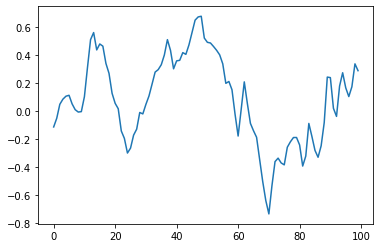

In [12]:
plt.plot(arma_dataset[1])

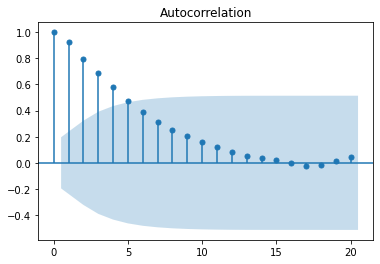

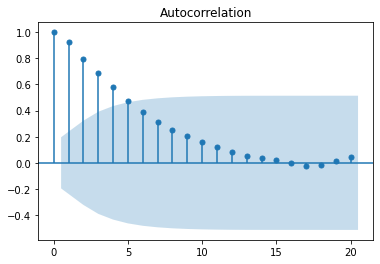

In [13]:
plot_acf(arma_dataset.dataset[5])

/home/wenjie/anaconda3/envs/torch190/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:652: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
/home/wenjie/anaconda3/envs/torch190/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:662: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


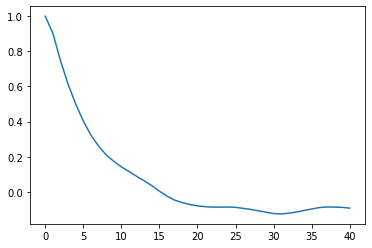

In [14]:
acf_array = []
for i in range(len(arma_dataset)):
    acf = sm.tsa.acf(arma_dataset[i])
    acf_array.append(acf)

acf_array = np.array(acf_array).mean(0)
plt.plot(acf_array)

/home/wenjie/anaconda3/envs/torch190/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:652: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
/home/wenjie/anaconda3/envs/torch190/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:662: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


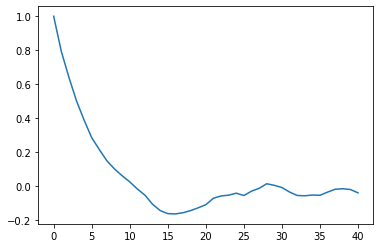

In [15]:
acf_array = []
i = 499
for j in range(len(fake_imgs[i])):
    acf = sm.tsa.acf(fake_imgs[i][j])
    acf_array.append(acf)

acf_array = np.array(acf_array).mean(0)
plt.plot(acf_array)

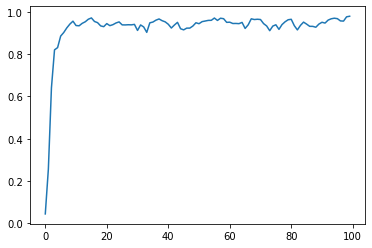

In [76]:
plt.plot(fake_imgs[440][0])